# ref

- [그래프 머신러닝](https://product.kyobobook.co.kr/detail/S000200738068)

- [github](https://github.com/PacktPublishing/Graph-Machine-Learning)

# GNN

## Unsupervised graph representation learning using Graph ConvNet

- 스펙트럼 그래프 합성곱

`-` 키프와 웰링이 제안한 정규화

$$H^t=\sigma(\hat D^{-\dfrac{1}{2}} \hat A \hat D^{-\dfrac{1}{2}}XW)$$

- $\hat D$는 $\hat A$의 대각 노드 차수 행렬

In [8]:
#from networkx import karate_club_graph, to_numpy_matrix
import numpy as np
import networkx as nx
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt

G = nx.barbell_graph(m1=10, m2=4)

order = np.arange(G.number_of_nodes())
A = nx.to_numpy_matrix(G, nodelist=order)
I = np.eye(G.number_of_nodes())

`-` 자체 루프 추가, 대각 노드 차수 행렬 준비

In [14]:
np.random.seed(7)

A_hat = A + np.eye(G.number_of_nodes()) # add self-connections  # G의 노드 수만큼 단위 행렬 만들기

D_hat = np.array(np.sum(A_hat, axis=0))[0]
D_hat = np.array(np.diag(D_hat))
D_hat = np.linalg.inv(sqrtm(D_hat))
# D_hat은 A_hat의 각 열의 합으로 이루어진 대각행렬의 역행렬
# 그래프 각 노드의 연결 강도를 정규화

A_hat = D_hat @ A_hat @ D_hat
#A_hat을 정규화된 그래프 연결 행렬로 


`-` 2개의 레이어로 구성된 GCN(그래프합성곱신경망)만들기

- 가중치 $W$

In [15]:
def glorot_init(nin, nout):  # 각  GCN의 가중치 행렬 난수로 초기화
  sd = np.sqrt(6.0 / (nin + nout))
  return np.random.uniform(-sd, sd, size=(nin, nout))

class GCNLayer():
  def __init__(self, n_inputs, n_outputs):
      self.n_inputs = n_inputs
      self.n_outputs = n_outputs
      self.W = glorot_init(self.n_outputs, self.n_inputs)
      self.activation = np.tanh
      
  def forward(self, A, X): #인접행렬과 피처행렬을 이용해 그래프 신경망을 순방향으로 계산. 결과 반환
      self._X = (A @ X).T # (N,N)*(N,n_outputs) ==> (n_outputs,N)
      H = self.W @ self._X # (N, D)*(D, n_outputs) => (N, n_outputs)
      H = self.activation(H)
      return H.T # (n_outputs, N)


`-` 네트워크 만들고 순방향 패스 계산. 네트워크를 통해 신호 전파

In [17]:

gcn1 = GCNLayer(G.number_of_nodes(), 8)
gcn2 = GCNLayer(8, 4)
gcn3 = GCNLayer(4, 2)

H1 = gcn1.forward(A_hat, I)   #중간 출력 
H2 = gcn2.forward(A_hat, H1)  #중간 출력
H3 = gcn3.forward(A_hat, H2)  #최종 결과

embeddings = H3  # 최종 결과

In [20]:
embeddings

matrix([[-0.01476752, -0.05053743],
        [-0.01476752, -0.05053743],
        [-0.01476752, -0.05053743],
        [-0.01476752, -0.05053743],
        [-0.01476752, -0.05053743],
        [-0.01476752, -0.05053743],
        [-0.01476752, -0.05053743],
        [-0.01476752, -0.05053743],
        [-0.01476752, -0.05053743],
        [-0.03171266, -0.05642689],
        [-0.08356075, -0.03146726],
        [-0.11696591, -0.00297877],
        [-0.10436451,  0.0226648 ],
        [-0.06008126,  0.01901998],
        [-0.00104536, -0.05409599],
        [ 0.01041858, -0.06209606],
        [ 0.01041858, -0.06209606],
        [ 0.01041858, -0.06209606],
        [ 0.01041858, -0.06209606],
        [ 0.01041858, -0.06209606],
        [ 0.01041858, -0.06209606],
        [ 0.01041858, -0.06209606],
        [ 0.01041858, -0.06209606],
        [ 0.01041858, -0.06209606]])

In [24]:
from gem.embedding.gf import GraphFactorization

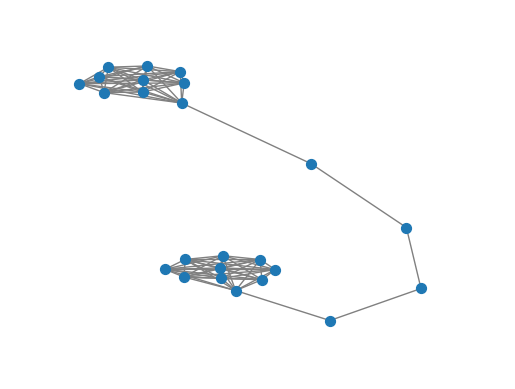

In [27]:
def draw_graph(G, filename=None, node_size=50):
  pos_nodes = nx.spring_layout(G)
  nx.draw_networkx(G, pos_nodes, with_labels=False, node_size=node_size, edge_color='gray')
  
  pos_attrs = {}
  for node, coords in pos_nodes.items():
    pos_attrs[node] = (coords[0], coords[1] + 0.08)

  plt.axis('off')
  axis = plt.gca()
  axis.set_xlim([1.2*x for x in axis.get_xlim()])
  axis.set_ylim([1.2*y for y in axis.get_ylim()])

embeddings = np.array(embeddings)
draw_graph(G)

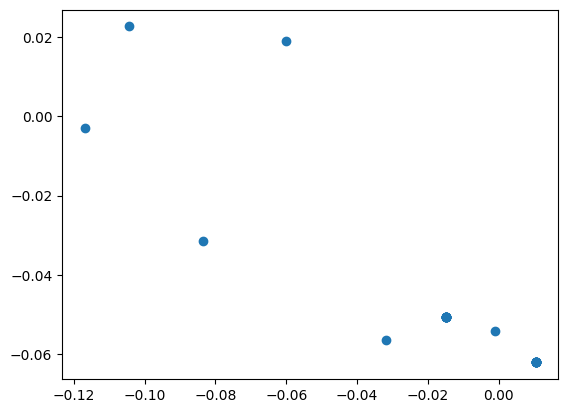

In [28]:
plt.scatter(embeddings[:, 0], embeddings[:, 1])
plt.savefig('embedding_gcn.png',dpi=300)

## Unsupervised GCN training using similarity graph distance

- StellarGraph 사용

- 대상 변수 없이 비지도 방식으로 벡터 삽입하는 방법

In [29]:
!pip install -q stellargraph[demos]==1.2.1

In [31]:
pip install chardet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 10.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [32]:
import pandas as pd
import numpy as np
import networkx as nx
import os

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN

import tensorflow as tf
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

`-` 데이터셋: PROTENIS


In [33]:
dataset = sg.datasets.PROTEINS()
display(HTML(dataset.description))
graphs, graph_labels = dataset.load()


- 39개 노드, 73개 간선이 있는 1,114개 그래프로 구성

- 각 노드는 4개의 속성으로 설명되며 두 클래스 중 하나에 속한다.

In [35]:
# let's print some info to better understand the dataset
print(graphs[0].info())
graph_labels.value_counts().to_frame()

StellarGraph: Undirected multigraph
 Nodes: 42, Edges: 162

 Node types:
  default: [42]
    Features: float32 vector, length 4
    Edge types: default-default->default

 Edge types:
    default-default->default: [162]
        Weights: all 1 (default)
        Features: none


,label
1,663
2,450


`-` 모델 만들기

In [36]:
# TODO
generator = sg.mapper.PaddedGraphGenerator(graphs)

In [37]:
# 64,32 사이즈의 레이어 2개를 포함한 GCN model 정의
# ReLU 활성화 함수는 레이어 간 비선형을 추가하고자 사용

gc_model = sg.layer.GCNSupervisedGraphClassification(
    [64, 32], ["relu", "relu"], generator, pool_all_layers=True
)

In [41]:
# 다음 레이어에 연결할 수 있도록 GC 레이어의 입력 및 출력 텐서 확인

In [42]:
inp1, out1 = gc_model.in_out_tensors()
inp2, out2 = gc_model.in_out_tensors()

vec_distance = tf.norm(out1 - out2, axis=1)

In [43]:
# 모델 생성, 임베딩을 찾기 쉽게 반사 모델 생성
pair_model = Model(inp1 + inp2, vec_distance)
embedding_model = Model(inp1, out1)

`-` 훈련

- 입력 그래프의 각 쌍에 유사성 점수 할당

- 단순화를 위해 그래프의 라플라시안 스펙트럼 사이의 거리 사용

In [44]:
def graph_distance(graph1, graph2):
    spec1 = nx.laplacian_spectrum(graph1.to_networkx(feature_attr=None))
    spec2 = nx.laplacian_spectrum(graph2.to_networkx(feature_attr=None))
    k = min(len(spec1), len(spec2))
    return np.linalg.norm(spec1[:k] - spec2[:k])

In [45]:
graph_idx = np.random.RandomState(0).randint(len(graphs), size=(100, 2))
targets = [graph_distance(graphs[left], graphs[right]) for left, right in graph_idx]
train_gen = generator.flow(graph_idx, batch_size=10, targets=targets)

<class 'networkx.utils.decorators.argmap'> compilation 20:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


`-` 모델 학습

In [46]:
pair_model.compile(optimizers.Adam(1e-2), loss="mse")

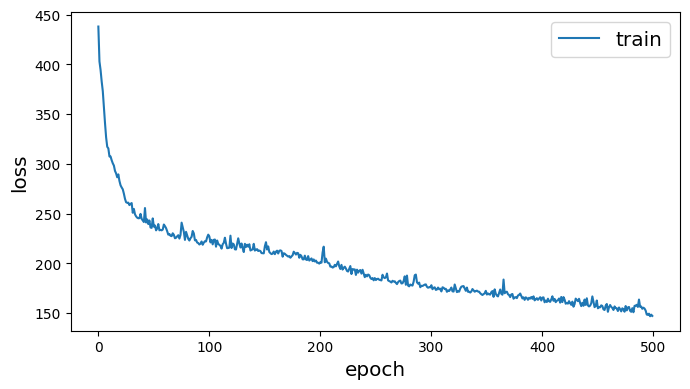

In [47]:
history = pair_model.fit(train_gen, epochs=500, verbose=0)
sg.utils.plot_history(history)

`-` 시각화

In [48]:
# 임베딩 검색

embeddings = embedding_model.predict(generator.flow(graphs))

1113/1113 [==============================] - 1s 531us/step


In [49]:
# 차원 축소를 위해 TSNE 사용
from sklearn.manifold import TSNE

tsne = TSNE(2)
two_d = tsne.fit_transform(embeddings)

- 출력이 32차원이므로 임베딩을 2차원 공간에 플로팅해 임베딩 정상적 평가

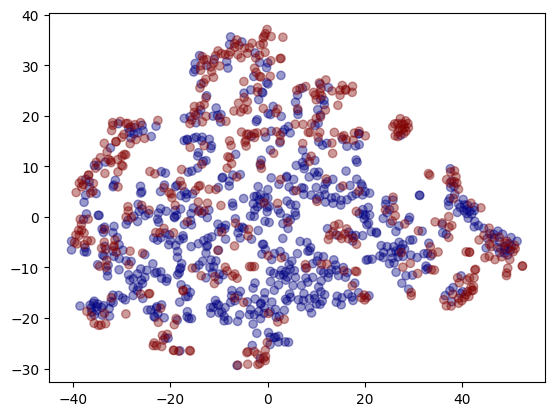

In [50]:
plt.scatter(two_d[:, 0], two_d[:, 1], c=graph_labels.cat.codes, cmap="jet", alpha=0.4)
plt.savefig('embedding_TSNE.png',dpi=300)

- 빨간색=1, 파란색=0